In [1]:
!pip install google_play_scraper
!pip install textblob
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00


In [2]:
from google_play_scraper import app
import pandas as pd
import numpy as np
import sklearn
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
#from wordcloud import WordCloud
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

import pickle
import re
import time
import datetime                              # access to %%time, for timing individual notebook cells
import os
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import seaborn styles explicitly
import seaborn as sns
# Apply the seaborn style before creating plots
sns.set_style("whitegrid")  # This line sets the Seaborn style

plt.rcParams["figure.figsize"] = (15,10)

In [3]:
from google.colab import files
uploaded = files.upload()

import io
import pandas as pd

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  # Assuming the uploaded file is a CSV
  try:
    df_mbbrev = pd.read_csv(io.BytesIO(uploaded[fn]))
    print("Successfully loaded CSV into df_mbbrev")
  except pd.errors.ParserError:
      print(f"Error: Could not parse {fn} as a CSV. Please upload a valid CSV file.")
      df_mbbrev = pd.DataFrame() # Create an empty DataFrame if parsing fails
  except Exception as e:
    print(f"An unexpected error occurred: {e}")
    df_mbbrev = pd.DataFrame()


Saving mybluebird_raw.csv to mybluebird_raw (1).csv
User uploaded file "mybluebird_raw (1).csv" with length 5138551 bytes
Successfully loaded CSV into df_mbbrev


In [4]:
df_mbbrev

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount,sentiment_rating,wordCount_after_stopwords
0,47de2ac3-fccf-4513-8bd1-47c20c1a021f,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,aplikasi sampah gabisa order sama sekali bener...,1,0,NaN,2025-09-06 12:55:11,"Dear Bapak/Ibu Fats Creamery, mohon maaf atas ...",2025-09-06 12:59:33,NaN,0.000000,0.00,10,0,0,Negative,10
1,84d05191-c99e-4677-a48c-e7929a7f4053,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,fantastic app service aaa+++,5,0,6.18.2,2025-09-04 09:05:11,"Dear Mr/Ms Anna Kingsford , thank you for the ...",2025-09-04 09:10:31,6.18.2,0.400000,0.90,4,0,3,Positive,4
2,ca8658f5-aa92-4dee-aec0-1abab5cef7e2,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,aplikasi bagus saja banyak supir2 baru ga tau ...,1,0,6.18.2,2025-09-04 02:08:46,Selamat pagi Bapak/Ibu mohon maaf atas ketidak...,2025-09-04 02:22:30,6.18.2,-0.100000,0.60,56,0,10,Negative,56
3,b9613d3b-1739-4d3f-a922-b2471d0dcc41,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,country taxi available,1,0,6.18.2,2025-09-03 17:10:23,"Dear Mr/Ms Motorola New app, apologize for the...",2025-09-03 17:14:49,6.18.2,0.400000,0.40,3,0,0,Negative,3
4,b2dea589-687d-4c6a-b22e-933405b57f00,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,efficient service. clean vehicles. language be...,4,0,6.18.2,2025-09-03 04:55:57,"Hi Kumar Sapre , thank you for the rating :) D...",2025-09-03 05:28:46,6.18.2,0.366667,0.70,8,0,3,Positive,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9657,2e7a5e6a-e376-47e4-b001-64fe97421afc,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,great app. sangat membantu.,4,1,1.2.127,2011-12-07 23:57:37,NaN,NaN,1.2.127,0.800000,0.75,4,0,2,Positive,4
9658,01814132-db78-47a4-914d-efd23e986e40,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"akhirnya di blackberry, dibuat aplikasi buat a...",5,1,1.2.126,2011-12-07 02:58:14,NaN,NaN,1.2.126,0.000000,0.10,14,0,7,Positive,14
9659,cdc031c1-088a-4619-928c-c7c1cd2d1e75,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"pagi jam 4 pesan taksi berjalan baik, muncul n...",4,2,1.2.126,2011-12-02 22:11:34,NaN,NaN,1.2.126,0.000000,0.00,17,0,3,Positive,17
9660,4d2cc639-e04a-40f5-86c8-d654a58f0886,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,pertama kali make app gw seneng banget gw trac...,2,2,1.2.126,2011-11-30 02:24:32,NaN,NaN,1.2.126,0.000000,0.00,19,0,2,Negative,19


In [5]:
df_mbbrev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9662 entries, 0 to 9661
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   reviewId                   9662 non-null   object 
 1   userName                   9662 non-null   object 
 2   userImage                  9662 non-null   object 
 3   content                    9598 non-null   object 
 4   score                      9662 non-null   int64  
 5   thumbsUpCount              9662 non-null   int64  
 6   reviewCreatedVersion       8698 non-null   object 
 7   at                         9662 non-null   object 
 8   replyContent               8562 non-null   object 
 9   repliedAt                  8562 non-null   object 
 10  appVersion                 8698 non-null   object 
 11  sentiment_polarity         9662 non-null   float64
 12  sentiment_subjective       9662 non-null   float64
 13  wordCount                  9662 non-null   int64

In [6]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

# Download Indonesian stopwords if not available
nltk.download('stopwords')
indonesian_stopwords = set(stopwords.words('indonesian'))

# Assuming the text column is named 'text', update accordingly
text_column = 'content'  # Change this if the column has a different name

# Combine all text data into one string
all_text = ' '.join(df_mbbrev[text_column].dropna().astype(str))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
#We do not need data for column reviewId, userName, userImage so
#we will show only these column
df_mbbrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,aplikasi sampah gabisa order sama sekali bener...,1,0,NaN,2025-09-06 12:55:11,"Dear Bapak/Ibu Fats Creamery, mohon maaf atas ...",2025-09-06 12:59:33
1,fantastic app service aaa+++,5,0,6.18.2,2025-09-04 09:05:11,"Dear Mr/Ms Anna Kingsford , thank you for the ...",2025-09-04 09:10:31
2,aplikasi bagus saja banyak supir2 baru ga tau ...,1,0,6.18.2,2025-09-04 02:08:46,Selamat pagi Bapak/Ibu mohon maaf atas ketidak...,2025-09-04 02:22:30
3,country taxi available,1,0,6.18.2,2025-09-03 17:10:23,"Dear Mr/Ms Motorola New app, apologize for the...",2025-09-03 17:14:49
4,efficient service. clean vehicles. language be...,4,0,6.18.2,2025-09-03 04:55:57,"Hi Kumar Sapre , thank you for the rating :) D...",2025-09-03 05:28:46
...,...,...,...,...,...,...,...
9657,great app. sangat membantu.,4,1,1.2.127,2011-12-07 23:57:37,NaN,NaN
9658,"akhirnya di blackberry, dibuat aplikasi buat a...",5,1,1.2.126,2011-12-07 02:58:14,NaN,NaN
9659,"pagi jam 4 pesan taksi berjalan baik, muncul n...",4,2,1.2.126,2011-12-02 22:11:34,NaN,NaN
9660,pertama kali make app gw seneng banget gw trac...,2,2,1.2.126,2011-11-30 02:24:32,NaN,NaN


##Stopwords Removal
Indonesian Stopwords

In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get Indonesian stopwords
indonesian_stopwords = stopwords.words('indonesian')

# Display first 20 stopwords
print(indonesian_stopwords[:20])

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
print(len(indonesian_stopwords))

758


,Word,Frequency
0,driver,1475
1,app,1305
2,aplikasi,1190
3,taxi,1033
4,yg,962
...,...,...
95,krn,145
96,bs,144
97,login,143
98,make,141


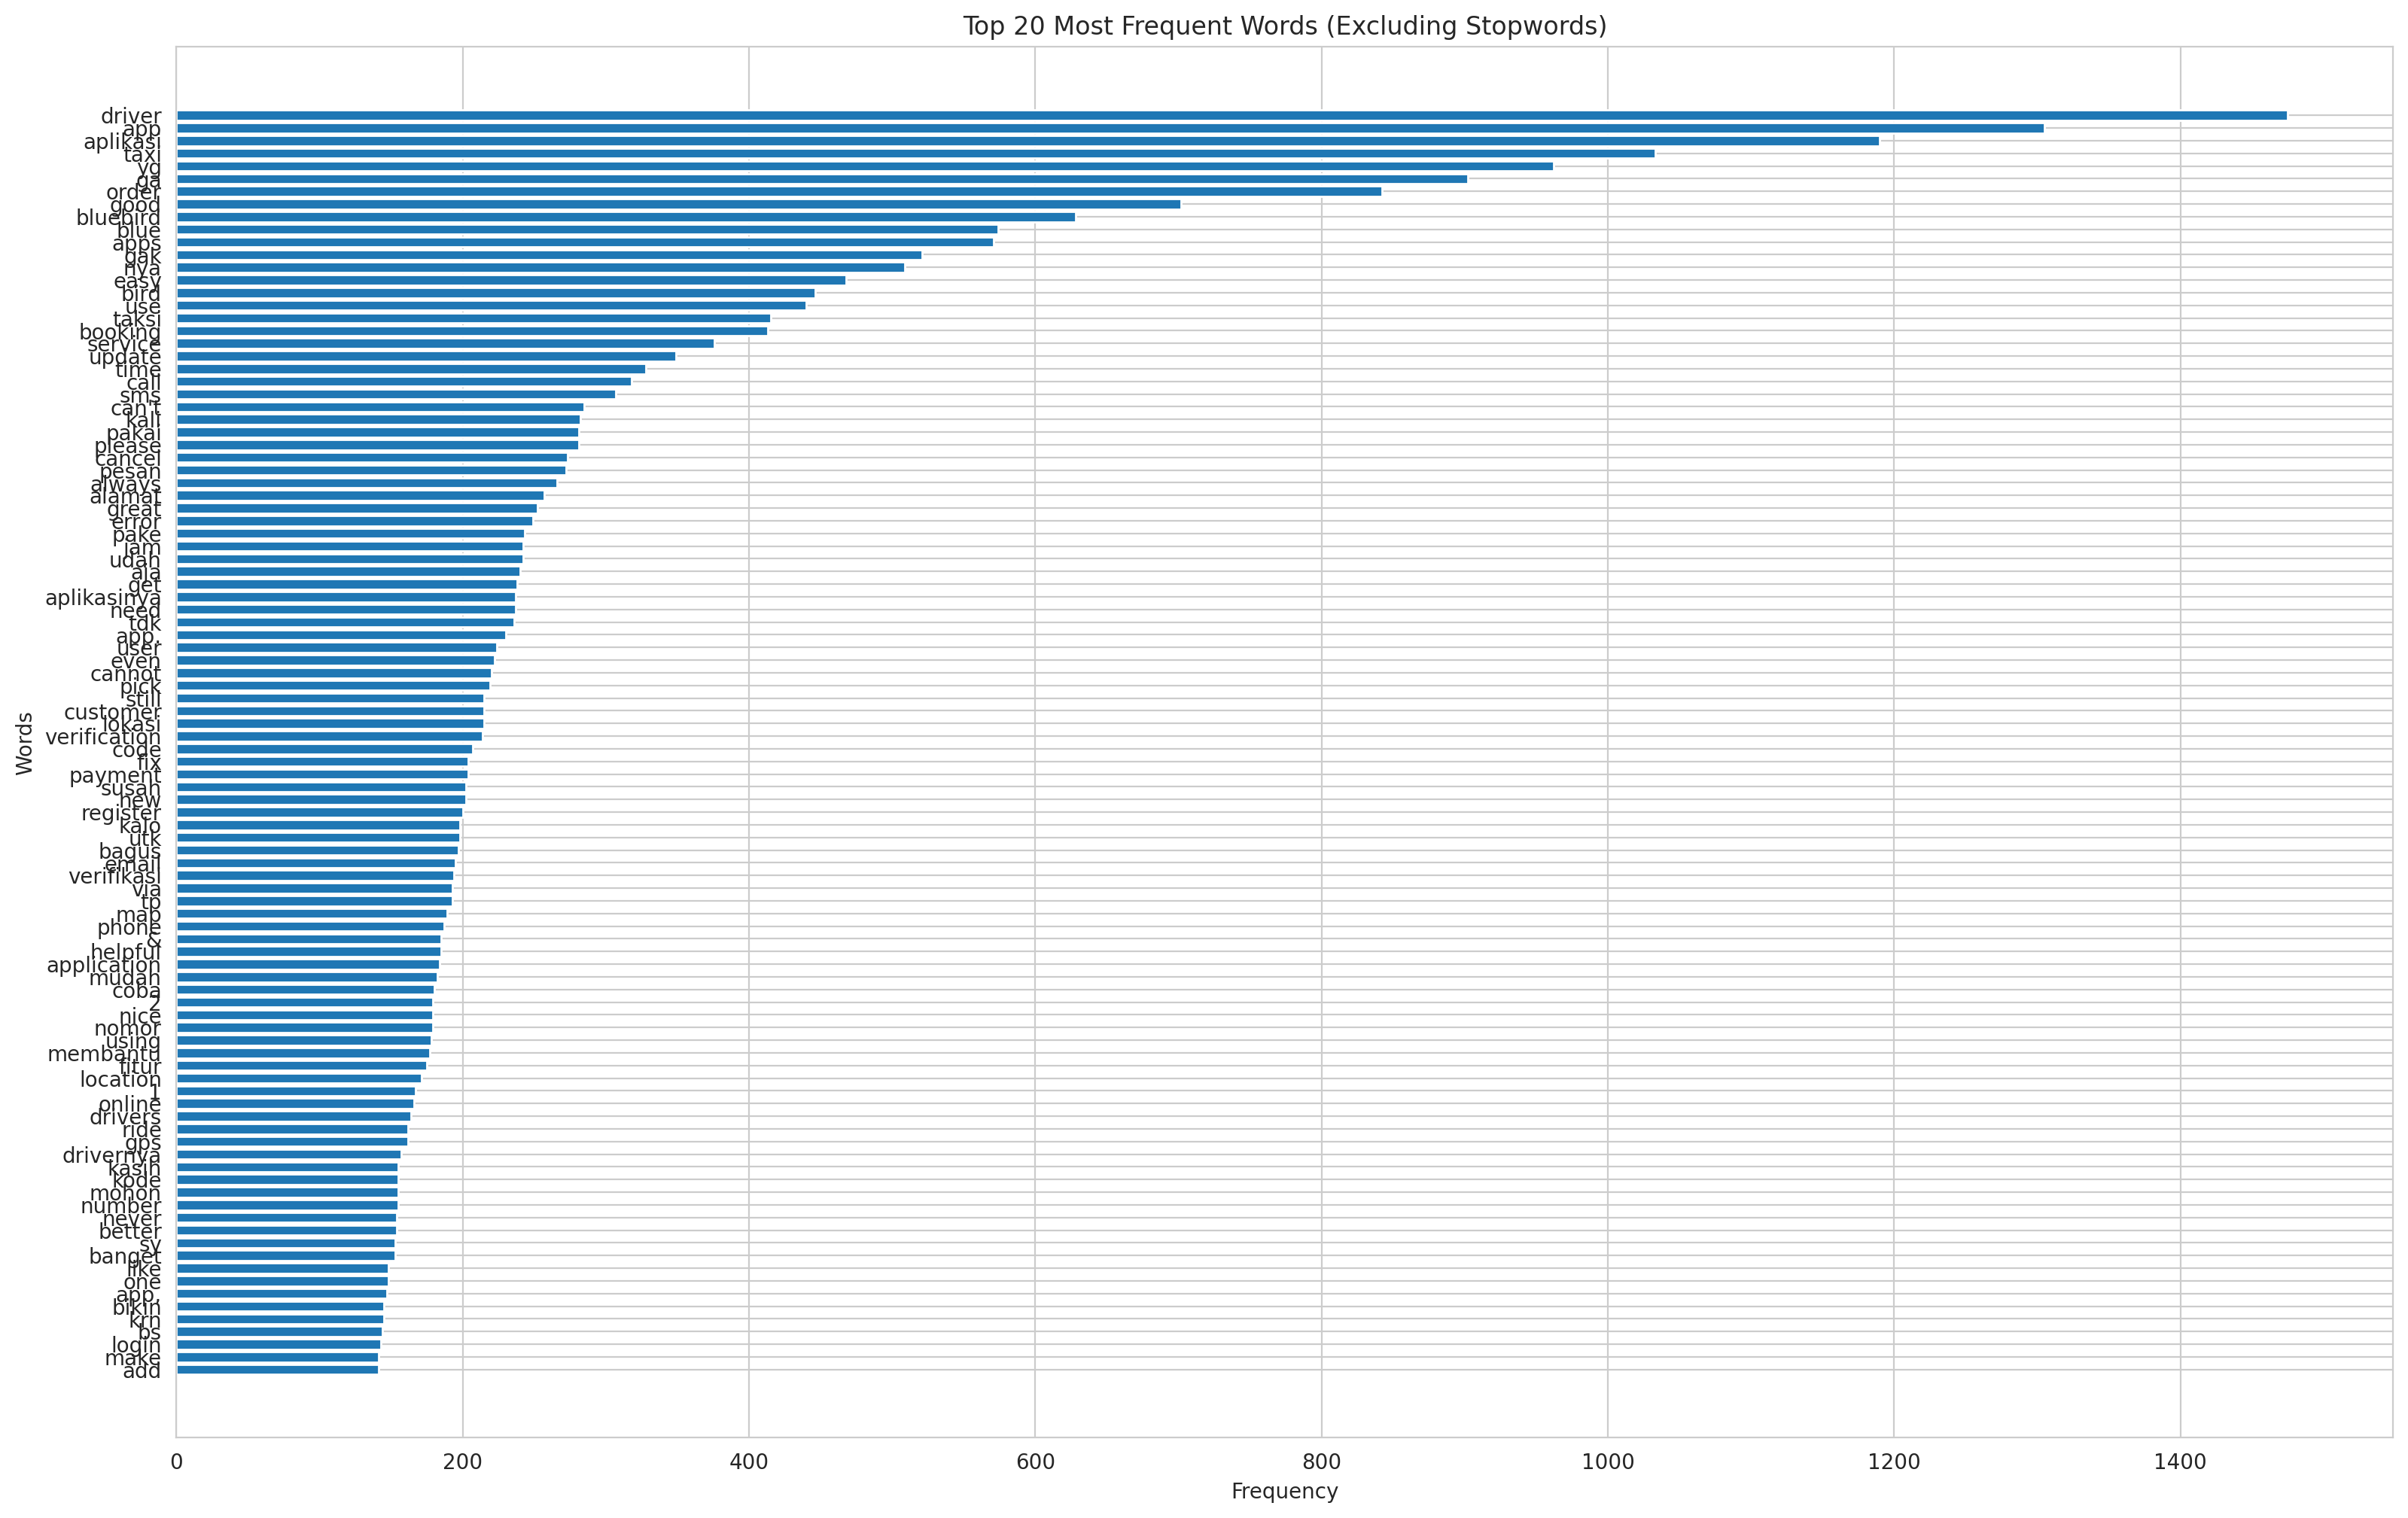

In [10]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

# Assuming the text column is named 'text', update accordingly
text_column = 'content'  # Change this if the column has a different name

# Combine all text data into one string
all_text = ' '.join(df_mbbrev[text_column].dropna().astype(str))

# Tokenize words and remove stopwords
words = all_text.split()
filtered_words = [word.lower() for word in words if word.lower() not in indonesian_stopwords]

# Count frequent words
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(100)

# Convert to DataFrame for better visualization
word_freq_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Display the most common words
display(word_freq_df)

# Plot the frequent words
plt.figure(figsize=(19, 12))
plt.barh(word_freq_df['Word'][::-1], word_freq_df['Frequency'][::-1])
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Frequent Words (Excluding Stopwords)")
plt.show()

In [11]:
common_words

[('driver', 1475),
 ('app', 1305),
 ('aplikasi', 1190),
 ('taxi', 1033),
 ('yg', 962),
 ('ga', 902),
 ('order', 842),
 ('good', 702),
 ('bluebird', 628),
 ('blue', 574),
 ('apps', 571),
 ('gak', 521),
 ('nya', 509),
 ('easy', 468),
 ('bird', 446),
 ('use', 440),
 ('taksi', 415),
 ('booking', 413),
 ('service', 376),
 ('update', 349),
 ('time', 328),
 ('call', 318),
 ('sms', 307),
 ("can't", 285),
 ('kali', 282),
 ('pakai', 281),
 ('please', 281),
 ('cancel', 273),
 ('pesan', 272),
 ('always', 266),
 ('alamat', 257),
 ('great', 252),
 ('error', 249),
 ('pake', 243),
 ('jam', 242),
 ('udah', 242),
 ('aja', 240),
 ('get', 238),
 ('aplikasinya', 237),
 ('need', 237),
 ('tdk', 236),
 ('app.', 230),
 ('user', 224),
 ('even', 222),
 ('cannot', 220),
 ('pick', 219),
 ('still', 215),
 ('customer', 215),
 ('lokasi', 215),
 ('verification', 214),
 ('code', 207),
 ('fix', 204),
 ('payment', 204),
 ('susah', 202),
 ('new', 202),
 ('register', 200),
 ('kalo', 198),
 ('utk', 198),
 ('bagus', 197),
 (